In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import VotingClassifier


# 显示所有列
# pd.set_option('display.max_columns', None)

# 显示所有列
# np.set_printoptions(threshold = np.inf)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

train = pd.read_csv(r'./train.csv')  # 训练数据
test = pd.read_csv(r'./test.csv')  # 测试数据
PassengerId = test['PassengerId']
# 合并训练数据和测试数据
all_data = pd.concat([train, test], ignore_index=True)  # ignore_index=True表示重建索引（行）

# 绘制Survived, Age的密度图
# facet = sns.FacetGrid(train, hue='Survived')
# facet.map(sns.kdeplot, 'Age', shade=True)
# facet.add_legend()
# facet.set(xlim=[0, train['Age'].max()])
# plt.xlabel('年龄')
# plt.ylabel('密度')

# 绘制Embarked和Survived的柱状图
# sns.countplot(x='Embarked', hue='Survived', data=train)

all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())

# sns.barplot(x='Title', y='Survived', data=all_data[all_data.Survived.notnull()])
# sns.countplot(x='Title', hue='Survived', data=all_data[all_data.Survived.notnull()])
# plt.xticks(rotation=45)  # 解决xlabel重叠问题

Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))


all_data['Title'] = all_data['Title'].map(Title_Dict)

all_data['FamilySize'] = all_data['Parch'] + all_data['SibSp'] + 1


# 新增FamilyLabel特征
# all_data.loc[(all_data['FamilySize'] >= 2) & (all_data['FamilySize'] <= 4), 'FamilyLabel'] = 2
# all_data.loc[((all_data['FamilySize'] > 4) & (all_data['FamilySize'] <= 7)) | (all_data['FamilySize'] == 1), 'FamilyLabel'] = 1
# all_data.loc[(all_data['FamilySize'] > 7), 'FamilyLabel'] = 0

def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel'] = all_data['FamilySize'].apply(Fam_label)

# 新增Deck特征，将Cabin中为空的数据填充成Unknown,然后提取首字母
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)

"""新增TicketGroup特征"""
Ticket_Count = dict(all_data['Ticket'].value_counts())
# all_data['TicketGroup'] = all_data['Ticket'].map(Ticket_Count)
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])

# 按生存率把TicketGroup分为三类
all_data.loc[(all_data['TicketGroup'] >= 2) & (all_data['TicketGroup'] <= 4), 'TicketGroup'] = 2
all_data.loc[((all_data['TicketGroup'] > 4) & (all_data['TicketGroup'] <= 8)) | (all_data['TicketGroup'] == 1), 'TicketGroup'] = 1
all_data.loc[(all_data['TicketGroup'] > 8), 'TicketGroup'] = 0
# sns.barplot(x='TicketGroup', y='Survived', data=all_data)

# 用Pclass,Sex,Title三个特征进行分组后年龄的中值填补Age缺失值
group_for_age = all_data.groupby(by=['Pclass', 'Sex', 'Title'])['Age'].mean()   # Series对象 'Pclass', 'Sex', 'Title'是索引
group_for_age = group_for_age.reset_index()[['Pclass', 'Sex', 'Title', 'Age']]
all_data.loc[all_data.Age.isnull(), 'Age'] = all_data.loc[all_data.Age.isnull()].apply(lambda x: group_for_age.loc[(group_for_age.Sex == x.Sex) & (group_for_age.Title == x.Title) & (group_for_age.Pclass == x.Pclass), 'Age'].values[0], axis=1)   # axis=1表示取每一行的数据

# 用Pclass,Sex,Title,Parch,SibSp这5个特征构建随机森林填充Age缺失值
# age_df = all_data[['Age', 'Sex', 'Title', 'Parch', 'SibSp', 'Pclass']]
# age_df = all_data[['Age', 'Sex', 'Title', 'Pclass']]
# age_df = pd.get_dummies(age_df)
# known_age = age_df[age_df.Age.notnull()].values
# unknown_age = age_df[age_df.Age.isnull()].values
# X = known_age[:, 1:]
# y = known_age[:, 0]
# rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
# rfr.fit(X, y)
# predictedAges = rfr.predict(unknown_age[:, 1:])
# all_data.loc[all_data.Age.isnull(), 'Age'] = predictedAges  # 填补

# 填补Embarked
# all_data.loc[all_data.Embarked.isnull(), 'Embarked'] = 'S'

all_data['Embarked'] = all_data['Embarked'].fillna('C')

# 填补Fare
# all_data.loc[all_data.Fare.isnull(), 'Fare'] = all_data.loc[(all_data.Pclass == 3) & (all_data.Embarked == 'S'), 'Fare'].mean()
fare = all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.mean()
all_data['Fare']=all_data['Fare'].fillna(fare)

In [2]:
# 新增Surname特征
all_data['Surname'] = all_data['Name'].apply(lambda x: x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].map(Surname_Count)

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  FamilySize   1309 non-null   int64  
 14  FamilyLabel  1309 non-null   int64  
 15  Deck         1309 non-null   object 
 16  TicketGroup  1309 non-null   int64  
 17  Surname      1309 non-null   object 
 18  FamilyGroup  1309 non-null   int64  
dtypes: flo

In [4]:
len(set(list(all_data.Surname.values)))

875

In [5]:
all_data.FamilyGroup.unique()

array([ 2,  1,  3,  5,  6, 11,  4,  8,  7], dtype=int64)

d:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='FamilyGroup', ylabel='Survived'>

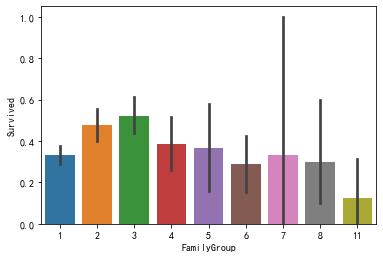

In [6]:
sns.barplot('FamilyGroup', 'Survived', data=all_data)

In [7]:
def sur_group_label(s):
    if s >= 2 and s <= 3:
        return 2
    elif (s > 3 and s <= 8) or s == 1:
        return 1
    elif s > 8:
        return 0
all_data['SurnameGroupLabel'] = all_data['FamilyGroup'].apply(lambda row: sur_group_label(row))

In [8]:
all_data['SurnameGroupLabel'].unique()

array([2, 1, 0], dtype=int64)

d:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='SurnameGroupLabel', ylabel='Survived'>

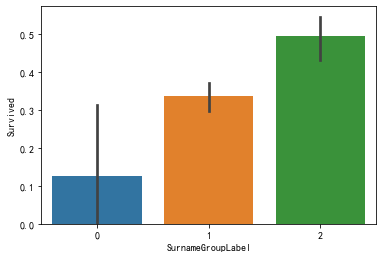

In [9]:
sns.barplot('SurnameGroupLabel', 'Survived', data=all_data)

In [11]:
Female_Child_Group = all_data.loc[(all_data.FamilyGroup >= 2) & ((all_data.Sex == 'female') | (all_data.Age <= 12)), :]  # 妇女儿童组

In [12]:
Female_Child_Group

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel,Deck,TicketGroup,Surname,FamilyGroup,SurnameGroupLabel
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,Mrs,2,2,C,2,Cumings,2,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,Mrs,2,2,C,2,Futrelle,2,2
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,Unknown,S,Master,5,1,U,1,Palsson,5,1
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,Unknown,S,Mrs,3,2,U,2,Johnson,6,1
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,Unknown,C,Mrs,2,2,U,2,Nasser,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,1292,NaN,1,"Bonnell, Miss. Caroline",female,30.00,0,0,36928,164.8667,C7,S,Miss,1,1,C,2,Bonnell,2,2
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.00,0,1,112378,59.4000,Unknown,C,Miss,2,2,U,2,Gibson,2,2
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.00,1,1,SOTON/O.Q. 3101315,13.7750,Unknown,S,Miss,3,2,U,2,Peacock,3,2
1302,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.00,1,0,19928,90.0000,C78,Q,Mrs,2,2,C,2,Minahan,3,2


In [19]:
Female_Child_Group.groupby(by=['Surname'])['Survived'].mean().values

array([1.        ,        nan, 1.        , 1.        , 1.        ,
       0.33333333, 0.14285714, 1.        , 1.        , 0.        ,
       0.75      , 1.        , 0.        , 1.        , 1.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
              nan, 1.        , 1.        , 0.        , 0.        ,
              nan,        nan, 1.        ,        nan,        nan,
       1.        , 0.        , 1.        , 0.        , 0.        ,
              nan, 1.        , 0.75      ,        nan,        nan,
       1.        ,        nan, 1.        ,        nan, 1.        ,
       1.        , 1.        , 1.        ,        nan, 1.        ,
              nan, 1.        , 1.        ,        nan, 0.        ,
              nan, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ,        nan, 1.        , 1.        ,
       1.        ,        nan, 1.        , 1.        , 0.        ,
       1.        , 1.        ,        nan, 1.        ,        

In [16]:
Male_Adult_Group = all_data.loc[(all_data.FamilyGroup >= 2) & (all_data.Sex == 'male') & (all_data.Age > 12), :]  # 男性成年组

In [21]:
Male_Adult_Group.groupby(by=['Surname'])['Survived'].mean().value_counts()

0.000000    122
1.000000     20
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64

In [171]:
a = all_data[(all_data.Survived == 0) & (all_data.FamilySize >= 2) & (all_data.Sex == 'female')].Surname.values
len(a)

54

In [172]:
a = set(a)

In [173]:
len(a)

30

In [174]:
all_data[(all_data.Survived.isnull()) & (all_data.Surname.isin(a))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilyLabel,Deck,TicketGroup,Surname,FamilyGroup,SurnameGroupLabel
909,910,NaN,3,"Ilmakangas, Miss. Ida Livija",female,27.000000,1,0,STON/O2. 3101270,7.9250,Unknown,S,Miss,2,2,U,1,Ilmakangas,2,2
916,917,NaN,3,"Robins, Mr. Alexander A",male,50.000000,1,0,A/5. 3337,14.5000,Unknown,S,Mr,2,2,U,2,Robins,2,2
924,925,NaN,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,32.326531,1,2,W./C. 6607,23.4500,Unknown,S,Mrs,4,2,U,2,Johnston,4,1
946,947,NaN,3,"Rice, Master. Albert",male,10.000000,4,1,382652,29.1250,Unknown,Q,Master,6,1,U,1,Rice,6,1
971,972,NaN,3,"Boulos, Master. Akar",male,6.000000,1,1,2678,15.2458,Unknown,C,Master,3,2,U,2,Boulos,4,1
1023,1024,NaN,3,"Lefebre, Mrs. Frank (Frances)",female,32.326531,0,4,4133,25.4667,Unknown,S,Mrs,5,1,U,1,Lefebre,5,1
1030,1031,NaN,3,"Goodwin, Mr. Charles Frederick",male,40.000000,1,6,CA 2144,46.9000,Unknown,S,Mr,8,0,U,1,Goodwin,8,1
1031,1032,NaN,3,"Goodwin, Miss. Jessie Allis",female,10.000000,5,2,CA 2144,46.9000,Unknown,S,Miss,8,0,U,1,Goodwin,8,1
1036,1037,NaN,3,"Vander Planke, Mr. Julius",male,31.000000,3,0,345763,18.0000,Unknown,S,Mr,4,2,U,2,Vander Planke,4,1
1040,1041,NaN,2,"Lahtinen, Rev. William",male,30.000000,1,1,250651,26.0000,Unknown,S,Officer,3,2,U,2,Lahtinen,2,2
